In [2]:
!pip install tensorflow keras opencv-python mtcnn scikit-learn matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 84.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
df = pd.read_csv("fer2013.csv")


In [4]:
import cv2
import numpy as np

X, y = [], []

# Define the expected dimensions for the image
image_width = 48
image_height = 48
expected_pixels_count = image_width * image_height

for i in range(len(df)):
    pixels_str = df['pixels'][i]
    pixels_list = pixels_str.split()
    current_pixels_count = len(pixels_list)

    if current_pixels_count != expected_pixels_count:
        # Handle cases where pixel data is not the expected size
        pixels_array_1d = np.array(pixels_list, dtype='uint8')

        if current_pixels_count < expected_pixels_count:
            # Pad with zeros if the pixel data is too short
            padding_needed = expected_pixels_count - current_pixels_count
            pixels_array_1d = np.pad(pixels_array_1d, (0, padding_needed), 'constant', constant_values=0)
        else: # current_pixels_count > expected_pixels_count
            # Truncate if the pixel data is too long
            pixels_array_1d = pixels_array_1d[:expected_pixels_count]

        # Now pixels_array_1d has exactly expected_pixels_count elements
        pixels = pixels_array_1d.reshape(image_height, image_width)
    else:
        # Data is correctly sized, proceed as original code intended
        pixels = np.array(pixels_list, dtype='uint8').reshape(image_height, image_width)

    # The original code then resized again. Keeping this step for consistency,
    # though it is redundant if 'pixels' is already (48,48).
    pixels = cv2.resize(pixels, (image_height, image_width))
    X.append(pixels)
    y.append(df['emotion'][i])

X = np.array(X).reshape(-1,image_height,image_width,1) / 255.0
y = np.array(y)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

emotion_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

emotion_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
emotion_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1
)


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 0.1920 - loss: 1.8904 - val_accuracy: 0.2286 - val_loss: 1.8248
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2253 - loss: 1.8382 - val_accuracy: 0.2286 - val_loss: 1.8025
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2262 - loss: 1.7988 - val_accuracy: 0.2643 - val_loss: 1.7812
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2355 - loss: 1.7785 - val_accuracy: 0.2429 - val_loss: 1.7513
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.2942 - loss: 1.7414 - val_accuracy: 0.2857 - val_loss: 1.7164
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.2995 - loss: 1.7203 - val_accuracy: 0.3000 - val_loss: 1.6833
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3077 - loss: 1.6843 - val_accuracy: 0.3500 - val_loss: 1.6418
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.3601 - loss: 1.6491 - val_accuracy: 0.3929 - 

In [8]:
emotion_model.evaluate(X_test, y_test)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.3239 - loss: 1.6373


[1.6938650608062744, 0.31142857670783997]

In [9]:
def add_occlusion(img):
    img = img.copy()
    x, y = np.random.randint(10,30), np.random.randint(10,30)
    img[x:x+10, y:y+15] = 0
    return img

X_occluded = np.array([add_occlusion(img[:,:,0]) for img in X])
X_occluded = X_occluded.reshape(-1,48,48,1)


In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

input_img = Input(shape=(48,48,1))

x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)

x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)

x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2,2))(x)

decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')


In [13]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

input_img = Input(shape=(48,48,1))

# -------- Encoder --------
x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)   # 48 → 24

x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)   # 24 → 12

# -------- Decoder --------
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)                   # 12 → 24

x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)                   # 24 → 48

decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')


In [14]:
autoencoder.fit(
    X_occluded, X,
    epochs=10,
    batch_size=64,
    validation_split=0.1
)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - loss: 0.0592 - val_loss: 0.0307
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0261 - val_loss: 0.0173
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0150 - val_loss: 0.0131
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0121 - val_loss: 0.0116
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0107 - val_loss: 0.0100
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0096 - val_loss: 0.0093
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0084 - val_loss: 0.0083
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0080 - val_loss: 0.0080
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0077 - val_loss: 0.0077


In [15]:
X_reconstructed = autoencoder.predict(X_occluded)


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


In [16]:
emotion_model.evaluate(X_reconstructed, y)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3497 - loss: 1.6419


[1.6480841636657715, 0.3558352291584015]

In [17]:
emotion_probs = emotion_model.predict(X_test)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [19]:
emotion_variance = np.var(emotion_probs, axis=1)


In [20]:
mental_state = []

for var in emotion_variance:
    if var < 0.01:
        mental_state.append("Calm")
    elif var < 0.05:
        mental_state.append("Stressed")
    else:
        mental_state.append("Anxious")


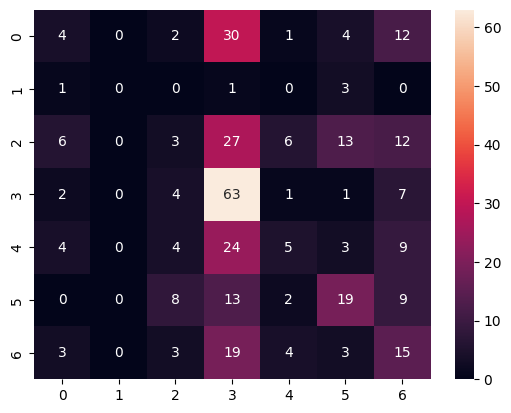

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, np.argmax(emotion_probs, axis=1))
sns.heatmap(cm, annot=True, fmt='d')
plt.show()


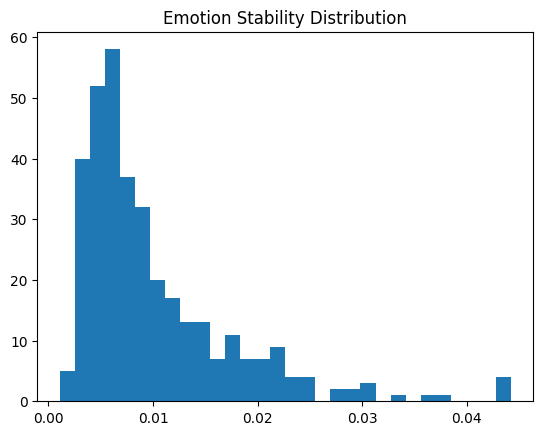

In [22]:
plt.hist(emotion_variance, bins=30)
plt.title("Emotion Stability Distribution")
plt.show()
